# Load data

In [1]:
import matplotlib.pyplot as plt
# Load packages
import pandas as pd

from config import (
  TYPICAL_HOURS, TYPICAL_WEEKDAYS,
  TYPICAL_DISTANCE_KM, TYPICAL_DURATION_MIN,
  TYPICAL_PASSENGERS, LAT_RANGE, LON_RANGE, TEST_SIZE, RANDOM_STATE
)
from modelling import split_train_test

In [2]:
# Load taxi and weather data
taxi_weather_data = pd.read_csv("data/taxi_weather_data.csv")

In [3]:
taxi_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1444229 entries, 0 to 1444228
Data columns (total 52 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1444229 non-null  object 
 1   vendor_id           1444229 non-null  int64  
 2   pickup_datetime     1444229 non-null  object 
 3   dropoff_datetime    1444229 non-null  object 
 4   passenger_count     1444229 non-null  int64  
 5   pickup_longitude    1444229 non-null  float64
 6   pickup_latitude     1444229 non-null  float64
 7   dropoff_longitude   1444229 non-null  float64
 8   dropoff_latitude    1444229 non-null  float64
 9   store_and_fwd_flag  1444229 non-null  object 
 10  trip_duration       1444229 non-null  int64  
 11  pickup_hour         1444229 non-null  int64  
 12  pickup_weekday      1444229 non-null  object 
 13  pickup_month        1444229 non-null  int64  
 14  hour_of_year        1444229 non-null  int64  
 15  trip_duration_m

In [4]:
taxi_weather_data.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
pickup_hour           0
pickup_weekday        0
pickup_month          0
hour_of_year          0
trip_duration_min     0
trip_duration_log     0
hav_dist_km           0
datetime_hour         0
humidity              0
fog                   0
rain                  0
snow                  0
conditions            0
datetime              0
hour_of_day           0
temp_c                0
windspeed_kph         0
precip_mm             0
pressure_hPa          0
precip_daily_mm       0
daily_snow_mm         0
rain_class            0
rain_code             0
snow_class            0
snow_code             0
cloud_class           0
cloud_code            0
hazy_class            0
hazy_code             0
freezing_class        0
freezing_code   

# split train and test set

In [5]:
train_set, test_set = split_train_test(taxi_weather_data, test_size=TEST_SIZE,
                                       random_state=RANDOM_STATE)

# Seek correlation

## correlation matrix (trip_dur and trip_dur_log)

In [7]:
corr_matrix = taxi_weather_data.select_dtypes(include='number').corr()

In [8]:
corr_matrix['trip_duration'].sort_values(ascending=False)
taxi_weather_data['trip_duration'].std()

656.1859997507663

- Not a strong predictor so far. Even distance is only weakly correlated
- No weather variable currently shows a significant linear correlation

In [9]:
corr_matrix['trip_duration_log'].sort_values(ascending=False)
taxi_weather_data['trip_duration_log'].std()

0.7283087228788941

- The log transformation of trip_duration has reduced the dispersion
- haversine_km - Strong correlation: longer distance → longer duration (logarithmically smoothed)
- pickup_longitude - Possible district effect
- Weather characteristics hardly show linear effects, they could have a non-linear effect or only be relevant at certain times or locations
- Geographical coordinates contribute significantly

## Filter haversine in combination

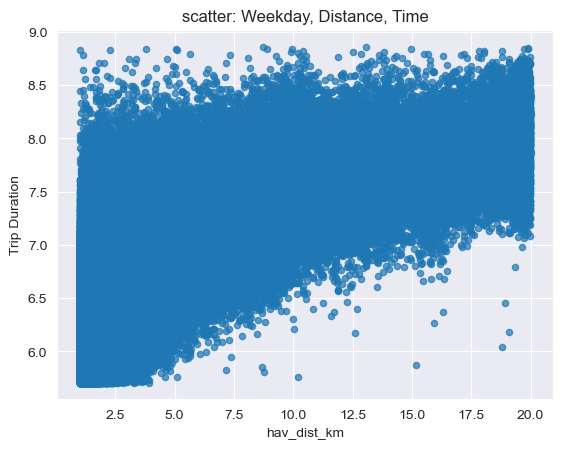

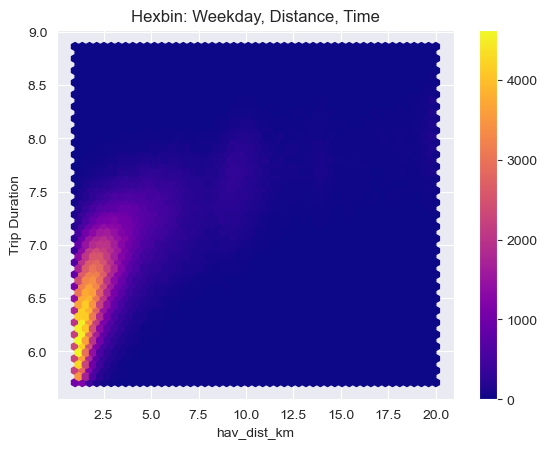

In [10]:
filtered = taxi_weather_data[
  (taxi_weather_data['trip_duration_min'].between(*TYPICAL_DURATION_MIN)) &
  (taxi_weather_data['hav_dist_km'].between(*TYPICAL_DISTANCE_KM)) &
  (taxi_weather_data['pickup_hour'].between(*TYPICAL_HOURS)) &
  (taxi_weather_data['pickup_weekday'].isin(TYPICAL_WEEKDAYS)) &
  (taxi_weather_data['passenger_count'].between(*TYPICAL_PASSENGERS)) &
  (taxi_weather_data['pickup_longitude'].between(*LON_RANGE)) &
  (taxi_weather_data['dropoff_longitude'].between(*LON_RANGE)) &
  (taxi_weather_data['pickup_latitude'].between(*LAT_RANGE)) &
  (taxi_weather_data['dropoff_latitude'].between(*LAT_RANGE))
  ]

filtered.plot.scatter(x="hav_dist_km", y="trip_duration_log", alpha=0.7, grid=True)
plt.xlabel("hav_dist_km")
plt.ylabel("Trip Duration")
plt.title("scatter: Weekday, Distance, Time")
plt.show()

filtered.plot.hexbin(
    x="hav_dist_km", y="trip_duration_log",
    gridsize=50, cmap='plasma'
)
plt.xlabel("hav_dist_km")
plt.ylabel("Trip Duration")
plt.title("Hexbin: Weekday, Distance, Time")
plt.grid(True)
plt.show()
# TODO: Add zone-based filtering (e.g. by longitude/latitude clusters or external zone map)

# Classify Weather Conditions